In [1]:
# required packages
import os
import numpy as np
import random
import pandas as pd
import seaborn as sns
import nltk
from textblob import TextBlob
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
sns.set(style = "whitegrid")
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# load data
raw_recipes = pd.read_csv('data/RAW_recipes.csv')
raw_interaction = pd.read_csv('data/RAW_interactions.csv')

In [3]:
# break up nutrition into different measurements
raw_recipes[
    ['calories', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']
] = raw_recipes['nutrition'].str.split(",",expand=True) 
raw_recipes['calories'] = raw_recipes['calories'].apply(lambda x: x.replace("[", ""))
raw_recipes['carbohydrates'] = raw_recipes['carbohydrates'].apply(lambda x: x.replace("]", ""))
raw_recipes[
    ['calories', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']
] =  raw_recipes[
    ['calories', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']
].astype(float)
# raw_recipes.head()

In [4]:
def iqr_bounds(col):
    q1 = np.percentile(raw_recipes[col],25)
    q3 = np.percentile(raw_recipes[col],75)
    iqr = q3 - q1
    return q1 - 1.5*iqr, q1 + 1.5*iqr

def drop_query(col, threshold, geq=True):
    """
    Helper to find indcies of observations that contains "unreasonable" values
    ---
    col: column to check
    threshold: threshold
    grq: if the cond will be >= (True), or <= (False)
    ---
    return indcies of observations have value >= or <= the threshold
    """
    if geq:
        return raw_recipes[raw_recipes[col] >= threshold].index.tolist()
    return raw_recipes[raw_recipes[col] <= threshold].index.tolist()

# choice 1 of dropped incies

# to_drop_idx = list(set(
#                 drop_query('calories', 5000) + \
#                 drop_query('total fat', 2000) + \
#                 drop_query('sugar', 1000) + \
#                 drop_query('sodium', 1000) + \
#                 drop_query('protein', 1000) + \
#                 drop_query('saturated fat', 1000) + \
#                 drop_query('carbohydrates', 2000) + \
#                 drop_query('minutes', 2000)
# ))

# choice 2 of dropped incies

to_drop_idx = []
for col in ['calories', 'total fat', 'sugar', 'sodium', 'protein', 
            'saturated fat', 'carbohydrates', 'minutes', 'n_steps', 'n_ingredients']:
    lower, upper = iqr_bounds(col)
    to_drop_idx+=drop_query(col, lower, False) + drop_query(col, upper, True)
to_drop_idx = list(set(to_drop_idx))

In [5]:
# drop observations
cleaned_recipes = raw_recipes.drop(labels=to_drop_idx, axis=0)
print(f'Dropped {raw_recipes.shape[0] - cleaned_recipes.shape[0]} observations')

Dropped 136910 observations


In [6]:
# determine if a recipe is for dessert
all_tags = defaultdict(int)
for obs in cleaned_recipes['tags']:
    for tag in obs[1:-1].replace("'", '').split(", "):
        all_tags[tag] += 1
cleaned_recipes['is_dessert'] = cleaned_recipes['tags'].apply(lambda x: 'desserts' in x)
cleaned_recipes['10_and_more_steps'] = cleaned_recipes['n_steps'].apply(lambda x: x >= 10)
cleaned_recipes['description_len'] = cleaned_recipes['description'].str.len().fillna(0)
# cleaned_recipes.head()

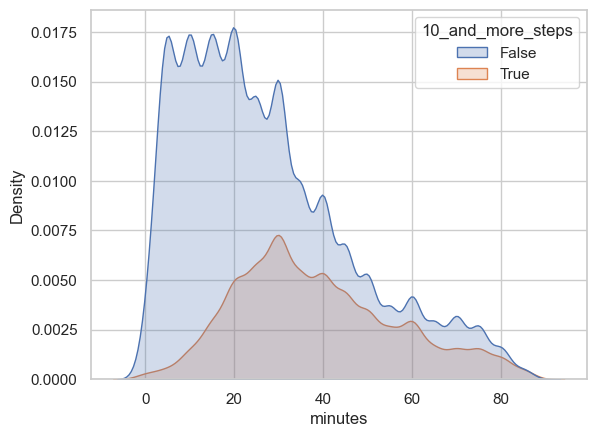

In [7]:
sns.kdeplot(data=cleaned_recipes, x='minutes', fill=True, hue='10_and_more_steps')
plt.show()

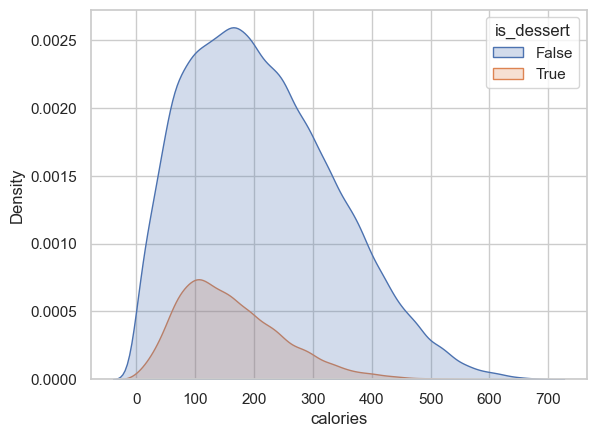

In [8]:
# sns.kdeplot(data=cleaned_recipes[['calories', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']], fill=True)
sns.kdeplot(data=cleaned_recipes, x='calories', fill=True, hue='is_dessert')
plt.show()

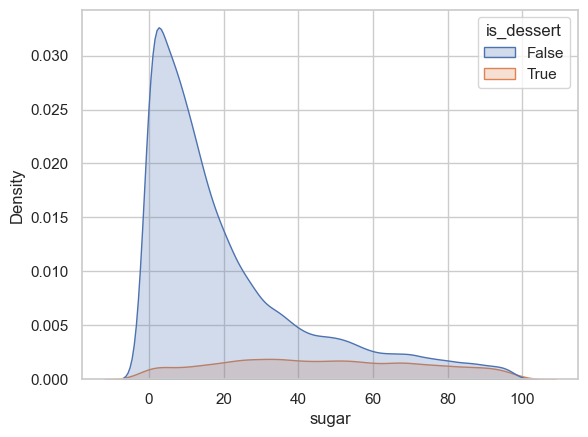

In [9]:
sns.kdeplot(data=cleaned_recipes, x='sugar', fill=True, hue='is_dessert')
plt.show()

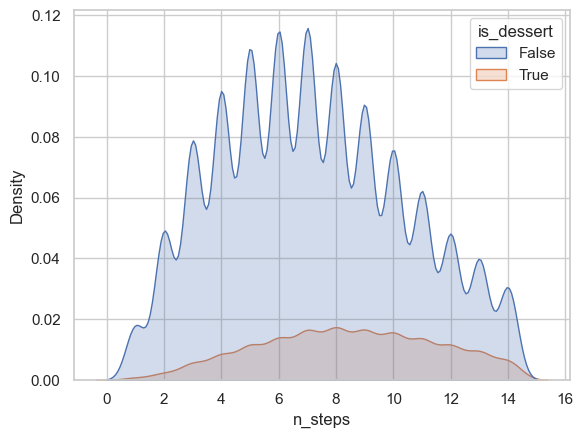

In [10]:
sns.kdeplot(data=cleaned_recipes, x='n_steps', fill=True, hue='is_dessert')
plt.show()

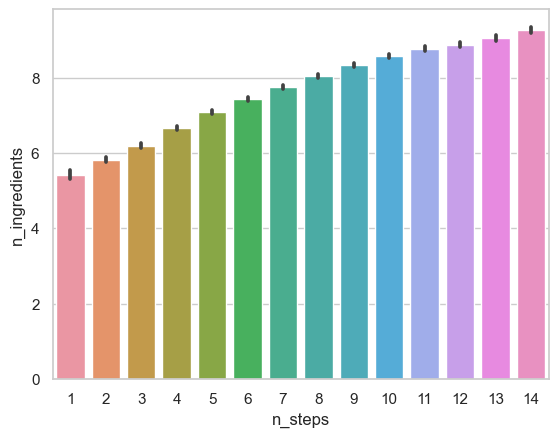

In [11]:
sns.barplot(data=cleaned_recipes, x="n_steps", y="n_ingredients")
plt.show()

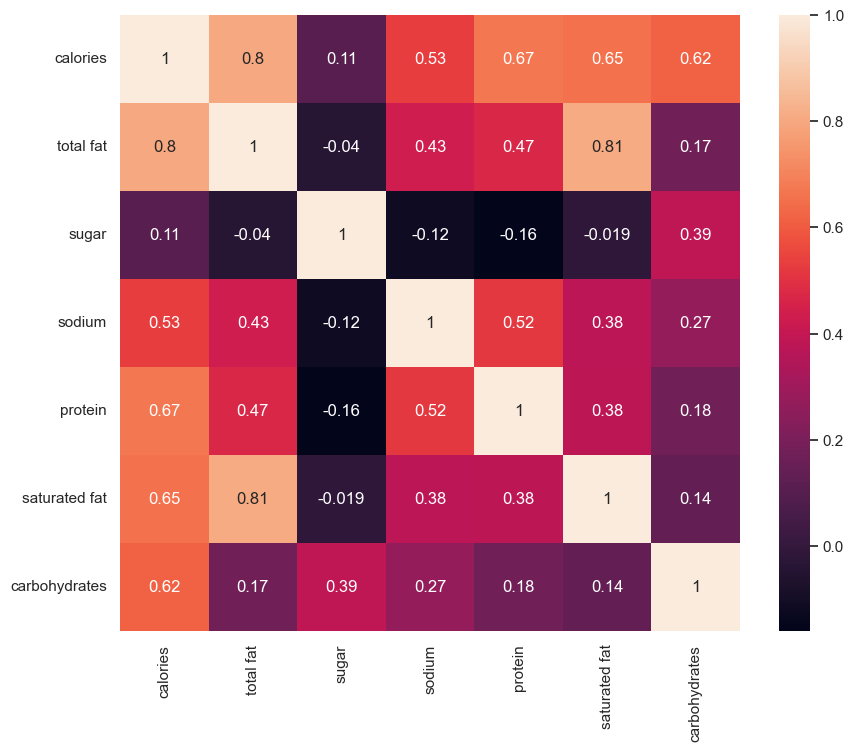

In [12]:
plt.figure(figsize=(10,8))
sns.heatmap(cleaned_recipes[
    ['calories', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']
].corr(), annot=True)
plt.show()

In [13]:
data = cleaned_recipes.merge(raw_interaction, left_on='id', right_on='recipe_id')
data = data.drop(columns='nutrition')
data = data.assign(steps=data['steps'].apply(lambda txt:txt[1:-1].replace("'", "")))
data.head()

,name,id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,...,saturated fat,carbohydrates,is_dessert,10_and_more_steps,description_len,user_id,recipe_id,date,rating,review
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...",11,"make a choice and proceed with recipe, dependi...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",...,0.0,4.0,False,True,194.0,4470,137739,2006-02-18,5,I used an acorn squash and recipe#137681 Swee...
1,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...",11,"make a choice and proceed with recipe, dependi...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",...,0.0,4.0,False,True,194.0,593927,137739,2010-08-21,5,This was a nice change. I used butternut squas...
2,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...",11,"make a choice and proceed with recipe, dependi...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",...,0.0,4.0,False,True,194.0,178427,137739,2011-12-05,5,Excellent recipe! I used butternut squash and ...
3,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...",9,"preheat oven to 425 degrees f, press dough int...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",...,35.0,1.0,False,False,180.0,28603,31490,2002-08-19,0,"Have not tried this, but it sounds delicious. ..."
4,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...",9,"preheat oven to 425 degrees f, press dough int...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",...,35.0,1.0,False,False,180.0,346277,31490,2006-08-27,5,This recipe was wonderful. Instead of using t...


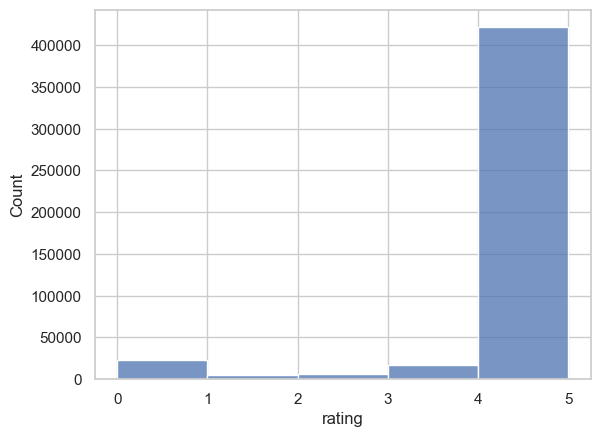

In [14]:
sns.histplot(data=data, x='rating', binwidth=1)
plt.show()

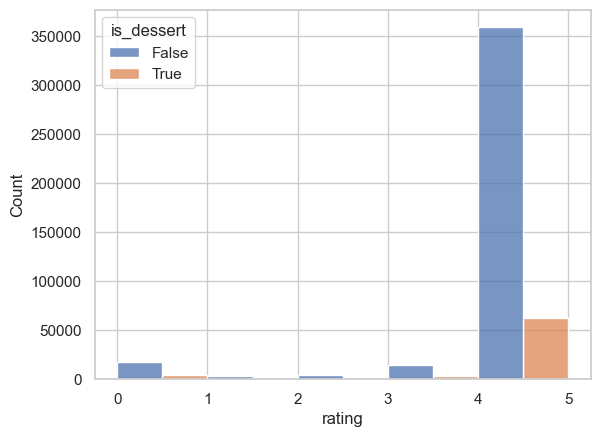

In [15]:
sns.histplot(data=data, hue='is_dessert', x='rating', multiple="dodge", binwidth=1)
plt.show()

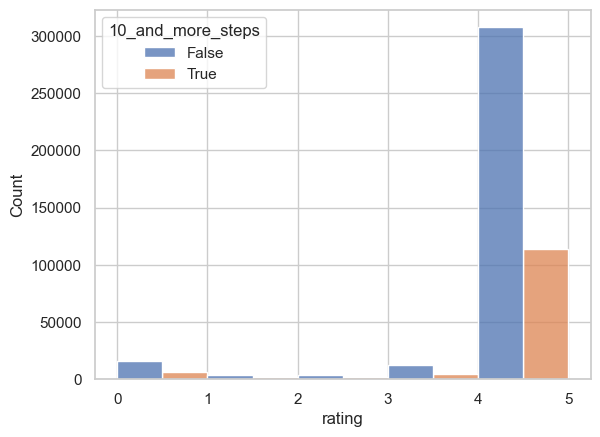

In [16]:
sns.histplot(data=data, hue='10_and_more_steps', x='rating', multiple="dodge", binwidth=1)
plt.show()

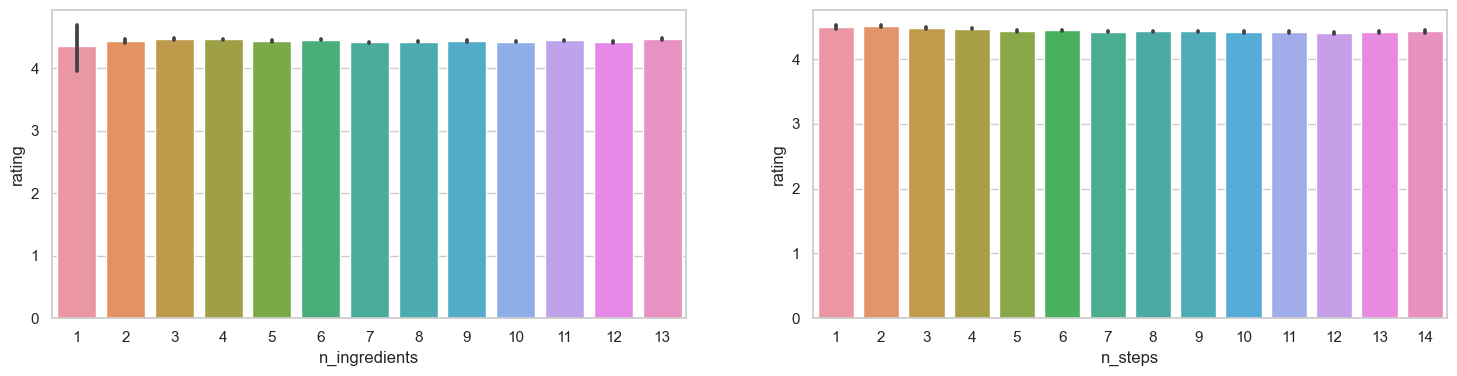

In [17]:
fig,ax = plt.subplots(1,2, figsize=(18,4))
sns.barplot(data=data, x="n_ingredients", y="rating", ax=ax[0])
sns.barplot(data=data, x="n_steps", y="rating", ax=ax[1])
plt.show()

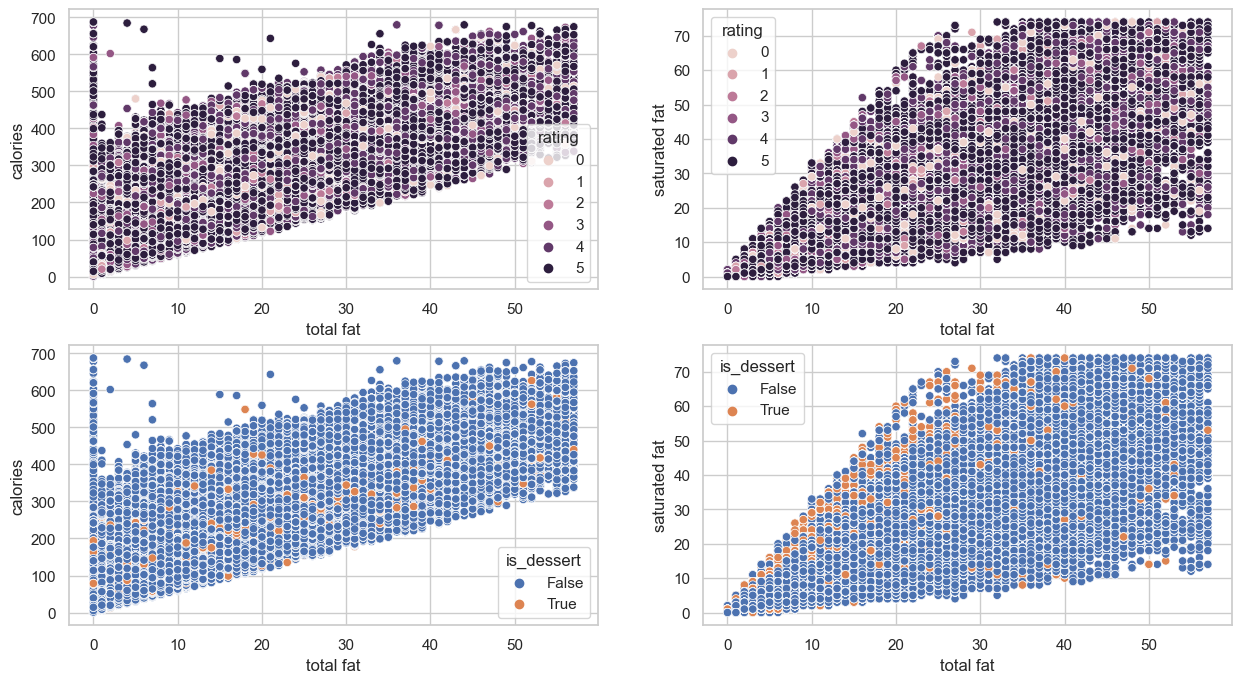

In [18]:
# takes a while to plot because there are lots of points
fig,ax = plt.subplots(2,2,figsize=(15,8))
sns.scatterplot(data=data, x="total fat", y="calories", hue="rating", ax=ax[0, 0])
sns.scatterplot(data=data, x="total fat", y="saturated fat", hue="rating", ax=ax[0, 1])
sns.scatterplot(data=data, x="total fat", y="calories", hue="is_dessert", ax=ax[1, 0])
sns.scatterplot(data=data, x="total fat", y="saturated fat", hue="is_dessert", ax=ax[1, 1])
plt.show()

In [19]:
np.random.seed(1)
is_adj = lambda pos: pos[:2] == 'JJ'

def extract_adj(txt):
    tokenized = nltk.word_tokenize(txt)
    adj = [word for (word, pos) in nltk.pos_tag(tokenized) if is_adj(pos)]
    return adj

In [20]:
def generate_word_cloud():
    word_cloud = []

    unique_ratings = sorted(data["rating"].unique())
    for rating in unique_ratings:
        temp_text = data[data["rating"]== rating]["review"]
        rand_idx = np.random.choice(range(0, len(temp_text)), 2500, replace=False)
        temp_text = temp_text.iloc[rand_idx]
        collapsed_temp_text = temp_text.str.cat(sep=' ')
        word_cloud += [extract_adj(collapsed_temp_text)]

    word_clouds = []
    for sub in word_cloud:
        counter = Counter(sub)
        most_occur = counter.most_common(100)
        word_clouds += [most_occur]

    word_clouds = [wc[3:-3] for wc in word_clouds]
    
    word_clouds = [{t[0]:t[1] for t in rate} for rate in word_clouds]

    for idx, rate in enumerate(word_clouds[1:]):
        wordcloud = WordCloud()
        wordcloud.generate_from_frequencies(frequencies=rate)
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title("Word Cloud For Rate " + str(idx+1))
        plt.axis("off")
        plt.show()

    

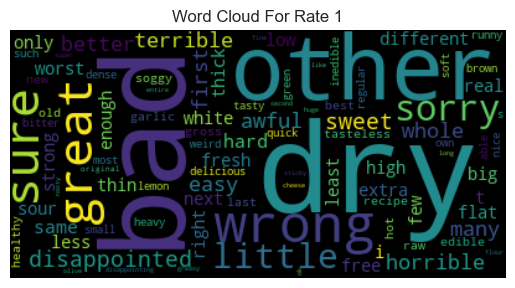

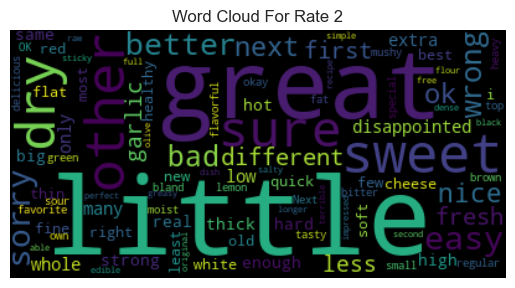

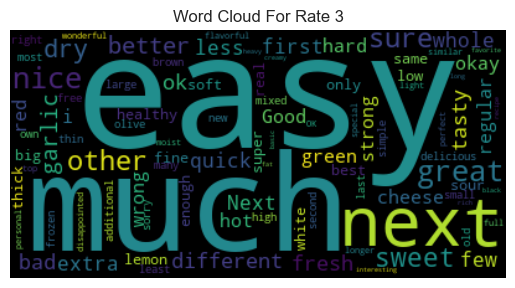

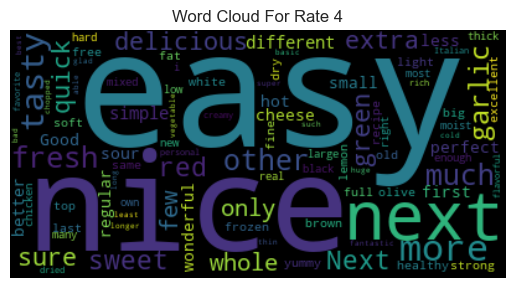

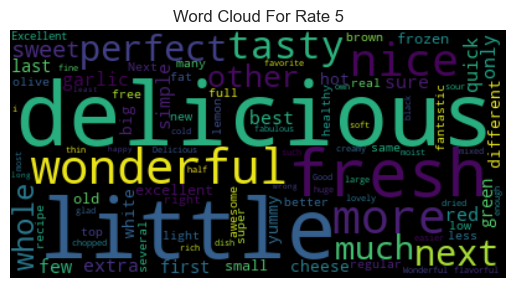

In [21]:
generate_word_cloud()